# EMOTION PREDICTION IN CONVERSATIONS:

## APPROACH :
- We will create a very basic first model first and then improve it using different other features. We will also see how deep neural networks can be used and end this post with some ideas about ensembling in general.

## This covers:
- TFIDF
- BOW
- logistic regression
- naive bayes
- svm
- xgboost
- grid search
- word vectors
- LSTM
- Customised Ensembling

## Research PAPER: https://arxiv.org/pdf/1810.02508.pdf

## DATASET : MELD : https://affective-meld.github.io/

## Metric Used:  MULTI CLASS LOG LOSS

In [1]:
cd drive/My\ Drive/MELD

/content/drive/My Drive/MELD


## LOAD DEPENDENCIES

In [2]:
import nltk
nltk.download('stopwords')

import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## LOAD DATA

In [3]:
train = pd.read_csv('train_sent_emo.csv')
cv = pd.read_csv('dev_sent_emo.csv')
test = pd.read_csv('test_sent_emo.csv')

## EXPLORATORY DATA ANALYSIS

In [4]:
train.shape, cv.shape , test.shape

((9989, 11), (1109, 11), (2610, 11))

In [5]:
train.columns

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')

In [6]:
cv.columns

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')

In [7]:
test.columns

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')

In [8]:
train.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: Emotion, dtype: int64


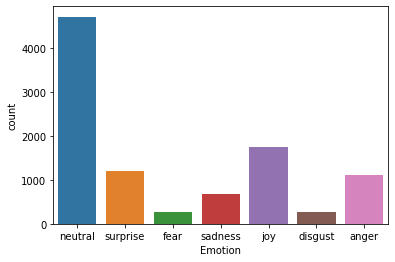

In [9]:
#Imbalanced Data
ax = sns.countplot(x=train['Emotion'], data=train)
print(train['Emotion'].value_counts())

neutral     470
joy         163
anger       153
surprise    150
sadness     111
fear         40
disgust      22
Name: Emotion, dtype: int64


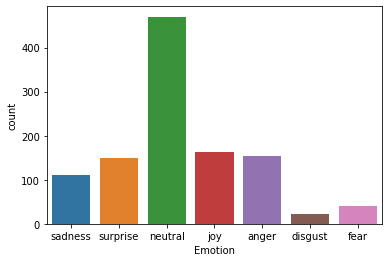

In [10]:
#Imbalanced Data
ax = sns.countplot(x=cv['Emotion'], data=cv)
print(cv['Emotion'].value_counts())

neutral     1256
joy          402
anger        345
surprise     281
sadness      208
disgust       68
fear          50
Name: Emotion, dtype: int64


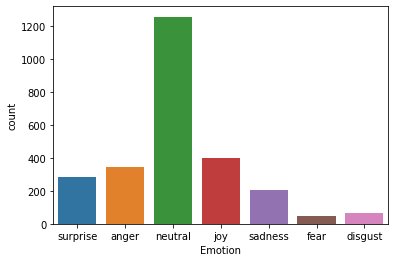

In [11]:
#Imbalanced Data
ax = sns.countplot(x=test['Emotion'], data=test)
print(test['Emotion'].value_counts())

### Observation : 
1. Neutral emotion is dominating in CV ,Test set and  Train set


In [12]:
train.info() #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9989 non-null   int64 
 1   Utterance     9989 non-null   object
 2   Speaker       9989 non-null   object
 3   Emotion       9989 non-null   object
 4   Sentiment     9989 non-null   object
 5   Dialogue_ID   9989 non-null   int64 
 6   Utterance_ID  9989 non-null   int64 
 7   Season        9989 non-null   int64 
 8   Episode       9989 non-null   int64 
 9   StartTime     9989 non-null   object
 10  EndTime       9989 non-null   object
dtypes: int64(5), object(6)
memory usage: 858.6+ KB


In [13]:
cv.info()  #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        1109 non-null   int64 
 1   Utterance     1109 non-null   object
 2   Speaker       1109 non-null   object
 3   Emotion       1109 non-null   object
 4   Sentiment     1109 non-null   object
 5   Dialogue_ID   1109 non-null   int64 
 6   Utterance_ID  1109 non-null   int64 
 7   Season        1109 non-null   int64 
 8   Episode       1109 non-null   int64 
 9   StartTime     1109 non-null   object
 10  EndTime       1109 non-null   object
dtypes: int64(5), object(6)
memory usage: 95.4+ KB


In [14]:
test.info()  #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


## Splits

In [15]:
X_train , y_train = train[['Utterance']] , train[['Emotion']]
X_cv , y_cv = cv[['Utterance']] , cv[['Emotion']]
X_test , y_test = test[['Utterance']] , test[['Emotion']]

## Defining Multi Class LogLoss

In [16]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

### Define a scorer to be used in Grid Search

In [17]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

## Using LabelEncoder to vectorise labels

In [18]:
lbl_enc = preprocessing.LabelEncoder()
y_train_enc = lbl_enc.fit_transform(y_train.Emotion.values)
y_cv_enc = lbl_enc.transform(y_cv.Emotion.values)
y_test_enc = lbl_enc.transform(y_test.Emotion.values)

In [149]:
y_train.Emotion.values[1:200]

array(['neutral', 'neutral', 'neutral', 'surprise', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'fear', 'neutral', 'surprise',
       'neutral', 'surprise', 'sadness', 'surprise', 'fear', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'joy', 'sadness',
       'surprise', 'neutral', 'disgust', 'sadness', 'neutral', 'neutral',
       'joy', 'neutral', 'joy', 'surprise', 'surprise', 'surprise',
       'neutral', 'neutral', 'neutral', 'surprise', 'sadness', 'neutral',
       'surprise', 'joy', 'surprise', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'joy', 'joy', 'joy', 'sadness', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'surprise',
       'joy', 'surprise', 'joy', 'neutral', 'neutral', 'anger', 'joy',
       'neutral', 'surprise', 'anger', 'anger', 'anger', 'neutral',
       'neutral', 'sadness', 'sadness', 'sadness', 'surprise', 'anger',
       'anger', 'anger', 'anger', 'neutral', 'anger', 'neutral',
     

In [148]:
y_train_enc[1:200]

array([4, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 6, 4, 6, 5, 6, 2, 4, 4, 4, 4, 4,
       3, 5, 6, 4, 1, 5, 4, 4, 3, 4, 3, 6, 6, 6, 4, 4, 4, 6, 5, 4, 6, 3,
       6, 4, 4, 4, 4, 4, 3, 3, 3, 5, 4, 4, 4, 4, 4, 4, 6, 3, 6, 3, 4, 4,
       0, 3, 4, 6, 0, 0, 0, 4, 4, 5, 5, 5, 6, 0, 0, 0, 0, 4, 0, 4, 4, 4,
       4, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 1, 0, 0, 0, 0, 0,
       0, 4, 4, 0, 4, 3, 4, 4, 3, 3, 3, 3, 4, 3, 1, 6, 1, 4, 2, 4, 6, 2,
       1, 0, 3, 4, 6, 4, 4, 4, 4, 6, 4, 4, 0, 4, 4, 5, 6, 5, 0, 5, 4, 5,
       4, 4, 4, 4, 4, 3, 0, 0, 0, 4, 0, 3, 3, 3, 3, 1, 6, 4, 4, 0, 3, 4,
       4, 2, 4, 2, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 2, 4, 5, 6, 2, 4, 4, 4,
       3])

## Data Preprocesing

In [19]:
import re

### Dataset Preprocessing training set
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
train_corpus = []
for i in range(0, len(X_train)):
    review = re.sub('[^a-zA-Z]', ' ', X_train['Utterance'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    train_corpus.append(review)

In [20]:
import re

### Dataset Preprocessing cv set
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
cv_corpus = []
for i in range(0, len(X_cv)):
    review = re.sub('[^a-zA-Z]', ' ', X_cv['Utterance'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    cv_corpus.append(review)

In [21]:
import re

### Dataset Preprocessing test set
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
test_corpus = []
for i in range(0, len(X_test)):
    review = re.sub('[^a-zA-Z]', ' ', X_test['Utterance'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    test_corpus.append(review)

In [90]:
X_train['clean_utterance'] = train_corpus
X_train.drop('Utterance',axis=1,inplace=True)

In [90]:
X_cv['clean_utterance'] = cv_corpus
X_cv.drop('Utterance',axis=1,inplace=True)

In [90]:
X_test['clean_utterance'] = test_corpus
X_test.drop('Utterance',axis=1,inplace=True)

# MODELLING

## MODEL 1: TFIDF + LR

In [119]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train['clean_utterance']) + list(X_cv['clean_utterance']) + list(X_test['clean_utterance']))
X_train_tfv =  tfv.transform(X_train['clean_utterance']) 
X_valid_tfv = tfv.transform(X_cv['clean_utterance'])
X_test_tfv = tfv.transform(X_test['clean_utterance'])

In [120]:
X_train_tfv.shape,X_valid_tfv.shape,X_test_tfv.shape

((9989, 3179), (1109, 3179), (2610, 3179))

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


alpha = [10 ** x for x in range(-6, 3)]


# initialize Our first RandomForestRegressor model...
regr2 = LogisticRegression()

# declare parameters for hyperparameter tuning
parameters = {'C':alpha} 

# Perform cross validation 
clf = GridSearchCV(regr2,
                    param_grid = parameters,
                    scoring=mll_scorer,
                    n_jobs = -1,
                    verbose = 10, refit=True, cv=2)
result = clf.fit(X_train_tfv, y_train_enc)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f 1(%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.1s finished


Best: -1.417605 using {'C': 1}
-1.536665 1(0.000177) with: {'C': 1e-06}
-1.536648 1(0.000177) with: {'C': 1e-05}
-1.536480 1(0.000177) with: {'C': 0.0001}
-1.534834 1(0.000178) with: {'C': 0.001}
-1.520896 1(0.000221) with: {'C': 0.01}
-1.463340 1(0.000332) with: {'C': 0.1}
-1.417605 1(0.004722) with: {'C': 1}
-1.622374 1(0.001400) with: {'C': 10}
-2.300202 1(0.032847) with: {'C': 100}


In [122]:
lr = LogisticRegression(C = 1)
lr.fit(X_train_tfv, y_train_enc)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Train,Test and CV loss


In [77]:
predictions = lr.predict_proba(X_train_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_train_enc, predictions))

logloss: 1.129 


In [75]:
predictions = lr.predict_proba(X_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_cv_enc, predictions))

logloss: 1.477 


In [76]:
predictions = lr.predict_proba(X_test_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, predictions))

logloss: 1.372 


## MODEL 2:BOW + LR

In [85]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train['clean_utterance']) + list(X_cv['clean_utterance']) + list(X_test['clean_utterance']))
X_train_ctv =  ctv.transform(X_train['clean_utterance']) 
X_valid_ctv = ctv.transform(X_cv['clean_utterance'])
X_test_ctv = ctv.transform(X_test['clean_utterance'])

In [79]:
X_train_ctv.shape,X_valid_ctv.shape,X_test_ctv.shape

((9989, 51082), (1109, 51082), (2610, 51082))

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


alpha = [10 ** x for x in range(-6, 3)]


# initialize Our first RandomForestRegressor model...
regr2 = LogisticRegression()

# declare parameters for hyperparameter tuning
parameters = {'C':alpha} 

# Perform cross validation 
clf = GridSearchCV(regr2,
                    param_grid = parameters,
                    scoring=mll_scorer,
                    n_jobs = -1,
                    verbose = 10, refit=True, cv=2)
result = clf.fit(X_train_ctv, y_train_enc)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f 1(%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   48.0s finished


Best: -1.427496 using {'C': 0.1}
-1.536658 1(0.000176) with: {'C': 1e-06}
-1.536569 1(0.000177) with: {'C': 1e-05}
-1.535706 1(0.000178) with: {'C': 0.0001}
-1.528054 1(0.000209) with: {'C': 0.001}
-1.489068 1(0.000305) with: {'C': 0.01}
-1.427496 1(0.001608) with: {'C': 0.1}
-1.460494 1(0.008207) with: {'C': 1}
-1.784036 1(0.024584) with: {'C': 10}
-2.629078 1(0.109224) with: {'C': 100}


In [81]:
lr = LogisticRegression(C = 0.1)
lr.fit(X_train_ctv, y_train_enc)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [82]:
predictions = lr.predict_proba(X_train_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_train_enc, predictions))

logloss: 1.115 


In [83]:
predictions = lr.predict_proba(X_valid_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_cv_enc, predictions))

logloss: 1.501 


In [84]:
predictions = lr.predict_proba(X_test_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, predictions))

logloss: 1.394 


### since MODEL 1 was better so we will move forward with TFIDF

## MODEL 3 : Word Vectors

In [29]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [30]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_utterance']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████| 9989/9989 [00:00<00:00, 70173.54it/s]

9989
300


In [31]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_utterance']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|██████████| 1109/1109 [00:00<00:00, 50739.39it/s]

1109
300


In [32]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_utterance']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████| 2610/2610 [00:00<00:00, 59699.37it/s]

2610
300


In [33]:
xtrain_glove = np.array(avg_w2v_vectors_train)
xvalid_glove = np.array(avg_w2v_vectors_cv)
xtest_glove = np.array(avg_w2v_vectors_test)

In [42]:
import xgboost as xgb

# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, y_train_enc)
predictions = clf.predict_proba(xvalid_glove)


print ("Valid logloss: %0.3f " % multiclass_logloss(y_cv_enc, predictions))


Valid logloss: 1.726 


## MODEL 4 : Truncated SVD + SVM

In [28]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(X_train_tfv)
X_train_svd = svd.transform(X_train_tfv)
X_valid_svd = svd.transform(X_valid_tfv)
X_test_svd = svd.transform(X_test_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(X_train_svd)
X_train_svd_scl = scl.transform(X_train_svd)
X_valid_svd_scl = scl.transform(X_valid_svd)
X_test_svd_scl = scl.transform(X_test_svd)

In [29]:
X_train_svd_scl.shape,X_valid_svd_scl.shape,X_test_svd_scl.shape

((9989, 120), (1109, 120), (2610, 120))

In [30]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

# initialize Our first RandomForestRegressor model...
svm = SVC(C=1)
regr2 = CalibratedClassifierCV(svm)
# declare parameters for hyperparameter tuning
regr2.fit(X_train_svd_scl, y_train_enc)



CalibratedClassifierCV(base_estimator=SVC(C=1, break_ties=False, cache_size=200,
                                          class_weight=None, coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='scale', kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=None, method='sigmoid')

In [31]:
predictions = regr2.predict_proba(X_train_svd_scl)
print ("logloss: %0.3f " % multiclass_logloss(y_train_enc, predictions))

logloss: 1.356 


In [32]:
predictions = regr2.predict_proba(X_valid_svd_scl)
print ("logloss: %0.3f " % multiclass_logloss(y_cv_enc, predictions))

logloss: 1.556 


In [33]:
predictions = regr2.predict_proba(X_test_svd_scl)
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, predictions))

logloss: 1.456 


# MODEL 5 : MLP

In [45]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)
xtest_glove_scl = scl.transform(xtest_glove)

In [46]:
y_train_enc_nn = np_utils.to_categorical(y_train_enc)
y_cv_enc_nn = np_utils.to_categorical(y_cv_enc)
y_test_enc_nn = np_utils.to_categorical(y_test_enc)

In [68]:
model = Sequential()

model.add(Dense(128, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(7))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [69]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               38528     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dense_19 (Dense)             (None, 256)              

In [70]:
y_cv_enc.shape

(1109,)

In [71]:
history = model.fit(xtrain_glove_scl, y=y_train_enc_nn, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xvalid_glove_scl, y_cv_enc_nn))

Train on 9989 samples, validate on 1109 samples
Epoch 1/10
9989/9989 [==============================] - 3s 262us/step - loss: 2.0361 - val_loss: 1.5816
Epoch 2/10
9989/9989 [==============================] - 2s 188us/step - loss: 1.6298 - val_loss: 1.5613
Epoch 3/10
9989/9989 [==============================] - 2s 186us/step - loss: 1.5424 - val_loss: 1.5323
Epoch 4/10
9989/9989 [==============================] - 2s 179us/step - loss: 1.4867 - val_loss: 1.5060
Epoch 5/10
9989/9989 [==============================] - 2s 181us/step - loss: 1.4608 - val_loss: 1.5041
Epoch 6/10
9989/9989 [==============================] - 2s 183us/step - loss: 1.4384 - val_loss: 1.4926
Epoch 7/10
9989/9989 [==============================] - 2s 180us/step - loss: 1.4248 - val_loss: 1.5016
Epoch 8/10
9989/9989 [==============================] - 2s 180us/step - loss: 1.4079 - val_loss: 1.4954
Epoch 9/10
9989/9989 [==============================] - 2s 182us/step - loss: 1.4059 - val_loss: 1.4948
Epoch 10/10
9989

In [76]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70
a =list(X_train['clean_utterance']) + list(X_cv['clean_utterance']) + list(X_test['clean_utterance'])
token.fit_on_texts(a)
xtrain_seq = token.texts_to_sequences(X_train['clean_utterance'])
xvalid_seq = token.texts_to_sequences(X_cv['clean_utterance'])
xtest_seq = token.texts_to_sequences(X_test['clean_utterance'])

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [77]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 4709/4709 [00:00<00:00, 1526114.78it/s]


# MODEL 6 : LSTM

In [81]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history=model.fit(xtrain_pad, y=y_train_enc_nn, batch_size=512, epochs=200, verbose=1, validation_data=(xvalid_pad, y_cv_enc_nn), callbacks=[earlystop])

Train on 9989 samples, validate on 1109 samples
Epoch 1/200
9989/9989 [==============================] - 7s 658us/step - loss: 1.9394 - val_loss: 1.9347
Epoch 2/200
9989/9989 [==============================] - 6s 584us/step - loss: 1.9256 - val_loss: 1.9239
Epoch 3/200
9989/9989 [==============================] - 6s 593us/step - loss: 1.9122 - val_loss: 1.9134
Epoch 4/200
9989/9989 [==============================] - 6s 573us/step - loss: 1.8992 - val_loss: 1.9032
Epoch 5/200
9989/9989 [==============================] - 6s 587us/step - loss: 1.8867 - val_loss: 1.8934
Epoch 6/200
9989/9989 [==============================] - 6s 585us/step - loss: 1.8744 - val_loss: 1.8839
Epoch 7/200
9989/9989 [==============================] - 6s 591us/step - loss: 1.8627 - val_loss: 1.8746
Epoch 8/200
9989/9989 [==============================] - 6s 589us/step - loss: 1.8512 - val_loss: 1.8656
Epoch 9/200
9989/9989 [==============================] - 6s 593us/step - loss: 1.8400 - val_loss: 1.8569
Epoch 1

### We would obviouslt get better results with LSTM but we need more epochs

# MODEL 7 : Bi -LSTM
One question could be: why do i use so much dropout? Well, fit the model with no or little dropout and you will that it starts to overfit :)

Let's see if Bi-directional LSTM can give us better results. Its a piece of cake to do it with Keras :)

In [82]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history=model.fit(xtrain_pad, y=y_train_enc_nn, batch_size=512, epochs=200, verbose=1, validation_data=(xvalid_pad, y_cv_enc_nn), callbacks=[earlystop])

Train on 9989 samples, validate on 1109 samples
Epoch 1/200
9989/9989 [==============================] - 13s 1ms/step - loss: 1.9397 - val_loss: 1.9351
Epoch 2/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.9259 - val_loss: 1.9240
Epoch 3/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.9122 - val_loss: 1.9135
Epoch 4/200
9989/9989 [==============================] - 11s 1ms/step - loss: 1.8991 - val_loss: 1.9033
Epoch 5/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.8864 - val_loss: 1.8934
Epoch 6/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.8742 - val_loss: 1.8838
Epoch 7/200
9989/9989 [==============================] - 11s 1ms/step - loss: 1.8623 - val_loss: 1.8745
Epoch 8/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.8508 - val_loss: 1.8655
Epoch 9/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.8396 - val_loss: 1.8567
Epoch 10/200
998

## MODEL 8 : Trying customised Ensembling

In [83]:
# this is the main ensembling class. how to use it is in the next cell!
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
import os
import sys
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s %(message)s",
    datefmt="%H:%M:%S", stream=sys.stdout)
logger = logging.getLogger(__name__)


class Ensembler(object):
    def __init__(self, model_dict, num_folds=3, task_type='classification', optimize=roc_auc_score,
                 lower_is_better=False, save_path=None):
        """
        Ensembler init function
        :param model_dict: model dictionary, see README for its format
        :param num_folds: the number of folds for ensembling
        :param task_type: classification or regression
        :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
        :param lower_is_better: is lower value of optimization function better or higher
        :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
        """

        self.model_dict = model_dict
        self.levels = len(self.model_dict)
        self.num_folds = num_folds
        self.task_type = task_type
        self.optimize = optimize
        self.lower_is_better = lower_is_better
        self.save_path = save_path

        self.training_data = None
        self.test_data = None
        self.y = None
        self.lbl_enc = None
        self.y_enc = None
        self.train_prediction_dict = None
        self.test_prediction_dict = None
        self.num_classes = None

    def fit(self, training_data, y, lentrain):
        """
        :param training_data: training data in tabular format
        :param y: binary, multi-class or regression
        :return: chain of models to be used in prediction
        """

        self.training_data = training_data
        self.y = y

        if self.task_type == 'classification':
            self.num_classes = len(np.unique(self.y))
            logger.info("Found %d classes", self.num_classes)
            self.lbl_enc = LabelEncoder()
            self.y_enc = self.lbl_enc.fit_transform(self.y)
            kf = StratifiedKFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, self.num_classes)
        else:
            self.num_classes = -1
            self.y_enc = self.y
            kf = KFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, 1)

        self.train_prediction_dict = {}
        for level in range(self.levels):
            self.train_prediction_dict[level] = np.zeros((train_prediction_shape[0],
                                                          train_prediction_shape[1] * len(self.model_dict[level])))

        for level in range(self.levels):

            if level == 0:
                temp_train = self.training_data
            else:
                temp_train = self.train_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):
                validation_scores = []
                foldnum = 1
                for train_index, valid_index in kf.split(self.train_prediction_dict[0], self.y_enc):
                    logger.info("Training Level %d Fold # %d. Model # %d", level, foldnum, model_num)

                    if level != 0:
                        l_training_data = temp_train[train_index]
                        l_validation_data = temp_train[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])
                    else:
                        l0_training_data = temp_train[0][model_num]
                        if type(l0_training_data) == list:
                            l_training_data = [x[train_index] for x in l0_training_data]
                            l_validation_data = [x[valid_index] for x in l0_training_data]
                        else:
                            l_training_data = l0_training_data[train_index]
                            l_validation_data = l0_training_data[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])

                    logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

                    if self.task_type == 'classification':
                        temp_train_predictions = model.predict_proba(l_validation_data)
                        self.train_prediction_dict[level][valid_index,
                        (model_num * self.num_classes):(model_num * self.num_classes) +
                                                       self.num_classes] = temp_train_predictions

                    else:
                        temp_train_predictions = model.predict(l_validation_data)
                        self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
                    validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
                    validation_scores.append(validation_score)
                    logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
                                validation_score)
                    foldnum += 1
                avg_score = np.mean(validation_scores)
                std_score = np.std(validation_scores)
                logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
                            avg_score, std_score)

            logger.info("Saving predictions for level # %d", level)
            train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
            train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
                                        index=False, header=None)

        return self.train_prediction_dict

    def predict(self, test_data, lentest):
        self.test_data = test_data
        if self.task_type == 'classification':
            test_prediction_shape = (lentest, self.num_classes)
        else:
            test_prediction_shape = (lentest, 1)

        self.test_prediction_dict = {}
        for level in range(self.levels):
            self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
                                                         test_prediction_shape[1] * len(self.model_dict[level])))
        self.test_data = test_data
        for level in range(self.levels):
            if level == 0:
                temp_train = self.training_data
                temp_test = self.test_data
            else:
                temp_train = self.train_prediction_dict[level - 1]
                temp_test = self.test_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):

                logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
                if level == 0:
                    model.fit(temp_train[0][model_num], self.y_enc)
                else:
                    model.fit(temp_train, self.y_enc)

                logger.info("Predicting Test Level %d. Model # %d", level, model_num)

                if self.task_type == 'classification':
                    if level == 0:
                        temp_test_predictions = model.predict_proba(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict_proba(temp_test)
                    self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
                                                                                        self.num_classes] = temp_test_predictions

                else:
                    if level == 0:
                        temp_test_predictions = model.predict(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict(temp_test)
                    self.test_prediction_dict[level][:, model_num] = temp_test_predictions

            test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
            test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
                                       index=False, header=None)

        return self.test_prediction_dict

In [87]:
import warnings
warnings.filterwarnings("ignore")
# specify the data to be used for every level of ensembling:
train_data_dict = {0: [X_train_tfv, X_train_ctv, X_train_tfv, X_train_ctv], 1: [xtrain_glove]}
test_data_dict = {0: [X_valid_tfv, X_valid_ctv, X_valid_tfv, X_valid_ctv], 1: [xvalid_glove]}

model_dict = {0: [LogisticRegression(), LogisticRegression(), MultinomialNB(alpha=0.1), MultinomialNB()],

              1: [xgb.XGBClassifier(silent=True, n_estimators=120, max_depth=7)]}

ens = Ensembler(model_dict=model_dict, num_folds=3, task_type='classification',
                optimize=multiclass_logloss, lower_is_better=True, save_path='')

ens.fit(train_data_dict, y_train_enc, lentrain=xtrain_glove.shape[0])
preds = ens.predict(test_data_dict, lentest=xvalid_glove.shape[0])

[10:31:55] INFO Found 7 classes
[10:31:55] INFO Training Level 0 Fold # 1. Model # 0
[10:31:57] INFO Predicting Level 0. Fold # 1. Model # 0
[10:31:57] INFO Level 0. Fold # 1. Model # 0. Validation Score = 1.425598
[10:31:57] INFO Training Level 0 Fold # 2. Model # 0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[10:31:58] INFO Predicting Level 0. Fold # 2. Model # 0
[10:31:58] INFO Level 0. Fold # 2. Model # 0. Validation Score = 1.402926
[10:31:58] INFO Training Level 0 Fold # 3. Model # 0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[10:31:59] INFO Predicting Level 0. Fold # 3. Model # 0
[10:31:59] INFO Level 0. Fold # 3. Model # 0. Validation Score = 1.408808
[10:31:59] INFO Level 0. Model # 0. Mean Score = 1.412444. Std Dev = 0.009607
[10:31:59] INFO Training Level 0 Fold # 1. Model # 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[10:32:07] INFO Predicting Level 0. Fold # 1. Model # 1
[10:32:07] INFO Level 0. Fold # 1. Model # 1. Validation Score = 1.475822
[10:32:07] INFO Training Level 0 Fold # 2. Model # 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[10:32:14] INFO Predicting Level 0. Fold # 2. Model # 1
[10:32:15] INFO Level 0. Fold # 2. Model # 1. Validation Score = 1.444641
[10:32:15] INFO Training Level 0 Fold # 3. Model # 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[10:32:21] INFO Predicting Level 0. Fold # 3. Model # 1
[10:32:22] INFO Level 0. Fold # 3. Model # 1. Validation Score = 1.463754
[10:32:22] INFO Level 0. Model # 1. Mean Score = 1.461406. Std Dev = 0.012837
[10:32:22] INFO Training Level 0 Fold # 1. Model # 2
[10:32:22] INFO Predicting Level 0. Fold # 1. Model # 2
[10:32:22] INFO Level 0. Fold # 1. Model # 2. Validation Score = 1.547975
[10:32:22] INFO Training Level 0 Fold # 2. Model # 2
[10:32:22] INFO Predicting Level 0. Fold # 2. Model # 2
[10:32:22] INFO Level 0. Fold # 2. Model # 2. Validation Score = 1.500929
[10:32:22] INFO Training Level 0 Fold # 3. Model # 2
[10:32:22] INFO Predicting Level 0. Fold # 3. Model # 2
[10:32:22] INFO Level 0. Fold # 3. Model # 2. Validation Score = 1.521596
[10:32:22] INFO Level 0. Model # 2. Mean Score = 1.523500. Std Dev = 0.019254
[10:32:22] INFO Training Level 0 Fold # 1. Model # 3
[10:32:22] INFO Predicting Level 0. Fold # 1. Model # 3
[10:32:22] INFO Level 0. Fold # 1. Model # 3. Validation

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[10:32:22] INFO Training Level 1 Fold # 1. Model # 0
[10:32:46] INFO Predicting Level 1. Fold # 1. Model # 0
[10:32:46] INFO Level 1. Fold # 1. Model # 0. Validation Score = 1.496972
[10:32:46] INFO Training Level 1 Fold # 2. Model # 0
[10:33:10] INFO Predicting Level 1. Fold # 2. Model # 0
[10:33:10] INFO Level 1. Fold # 2. Model # 0. Validation Score = 1.462039
[10:33:10] INFO Training Level 1 Fold # 3. Model # 0
[10:33:35] INFO Predicting Level 1. Fold # 3. Model # 0
[10:33:35] INFO Level 1. Fold # 3. Model # 0. Validation Score = 1.476698
[10:33:35] INFO Level 1. Model # 0. Mean Score = 1.478570. Std Dev = 0.014322
[10:33:35] INFO Saving predictions for level # 1
[10:33:35] INFO Training Fulldata Level 0. Model # 0
[10:33:37] INFO Predicting Test Level 0. Model # 0
[10:33:37] INFO Training Fulldata Level 0. Model # 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[10:33:44] INFO Predicting Test Level 0. Model # 1
[10:33:44] INFO Training Fulldata Level 0. Model # 2
[10:33:44] INFO Predicting Test Level 0. Model # 2
[10:33:44] INFO Training Fulldata Level 0. Model # 3
[10:33:44] INFO Predicting Test Level 0. Model # 3
[10:33:45] INFO Training Fulldata Level 1. Model # 0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[10:34:21] INFO Predicting Test Level 1. Model # 0


In [88]:
# check error:
multiclass_logloss(y_cv_enc, preds[1])

1.5316193489752536

In [91]:
# Also check train error
preds = ens.predict(train_data_dict, lentest=xtrain_glove.shape[0])
multiclass_logloss(y_train_enc, preds[1])

[10:52:30] INFO Training Fulldata Level 0. Model # 0
[10:52:31] INFO Predicting Test Level 0. Model # 0
[10:52:31] INFO Training Fulldata Level 0. Model # 1
[10:52:39] INFO Predicting Test Level 0. Model # 1
[10:52:39] INFO Training Fulldata Level 0. Model # 2
[10:52:39] INFO Predicting Test Level 0. Model # 2
[10:52:39] INFO Training Fulldata Level 0. Model # 3
[10:52:39] INFO Predicting Test Level 0. Model # 3
[10:52:40] INFO Training Fulldata Level 1. Model # 0
[10:53:14] INFO Predicting Test Level 1. Model # 0


1.0485667689038733

# INFERENCE MODELLING:

In [94]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(ens, 'custom_ensembler.pkl') 
joblib.dump(model, 'lstm.pkl') 
joblib.dump(lr, 'lr2.pkl') 
joblib.dump(tfv, 'tfidf.pkl') 

### Utility Functions:

In [95]:
import re

### Dataset Preprocessing 
from nltk.stem.porter import PorterStemmer
def preprocessor(sentence):
  ps = PorterStemmer()

  review = re.sub('[^a-zA-Z]', ' ', sentence)
  review = review.lower()
  review = review.split()

  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  return review

In [151]:
def mapper(ans):
  for i in ans:
    if ans==0:
      return 'Anger'
    elif ans==1:
      return 'Disgust'
    elif ans==2:
      return 'Fear'
    elif ans==3:
      return 'Joy'
    elif ans==4:
      return 'Neutral'
    elif ans==5:
      return 'Sadness'
    elif ans==6:
      return 'Surprise'
    
    

In [152]:
from sklearn.externals import joblib 
def predictor(sentence):
  lst = []
  my_model = joblib.load('lr2.pkl') 
  tfv = joblib.load('tfidf.pkl')  

  sent = preprocessor(sentence)

  lst.append(sent)
  sent_tfv = tfv.transform(lst)
  ans = my_model.predict(sent_tfv) 
  mapped_ans = mapper(ans)
  return mapped_ans

## Let's Predict

In [153]:
ans = predictor('I hate you from bottom of my heart')
print(ans)

Anger


In [154]:
ans = predictor('Oh Wow what a beautiful place')
print(ans)

Joy


In [158]:
ans = predictor('I am really sorry , i am feeling reaaly very sad')
print(ans)

Sadness


# CONCLUSION:
1. The results of Infernece model are okay'ish since we used Logistic Regression + TFIDF which performed awesome.
1. We see that ensembling improves the score by a great extent! 
2. LSTM can win this with higher number of epochs or altering the learnng rate. 
